In [3]:
import re
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import shutil
import posixpath
import seaborn as sns
import joblib
import sklearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [57]:
import sys
import os
import keras as ks
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l2
from keras import backend as K
from keras import objectives
import scipy.io as scio
import gzip
from six.moves import cPickle
import sys, random
from sklearn.model_selection import train_test_split

import math
from sklearn import mixture
from sklearn.cluster import KMeans
from keras.models import model_from_json
import json
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from scipy.ndimage import gaussian_filter
from collections import defaultdict
from scipy.ndimage import label
import warnings

import itertools
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, auc, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn import metrics
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


import pickle
warnings.filterwarnings("ignore")




from numpy import array
import keras 
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
class data_generator:
 
##This class has essential functions supporting fast and effective computation 
#for reading the raw data, droping the irrelevant lables, 
#preparing the input data and generating the batch to be used in NN model.
       
    
    def __init__(self, path_to_data = 'None'):
        super().__init__()
        self.path = path_to_data
        self.signals = self.resampled_signals()
        self.users = list(self.signals.keys())
        self.train_users, self.validation_users = train_test_split(self.users, test_size = 0.3, random_state = 0)
        self.validation_users, self.test_users = train_test_split(self.validation_users, test_size = 0.5, random_state = 123)

    def resampled_signals(self):
        acc_eda_temp_dic = {}
        files = [file for file in glob.glob('stress_data/Acc_Temp_EDA/*.csv')]
        column_labels = ["Hr", "Min", "Sec", "Accz", "Accy", "Accx", "Temp", "EDA", "Label"]
        #subjects = set(file.split('/')[-1].split('Acc'))
        for subject in tqdm(files):
            file = pd.read_csv(subject)#, names = column_labels)
            file.drop(labels = ['Hour', 'Minute', 'Second'], axis =1, inplace = True)

            # prepare target
            le = LabelEncoder()
            le.fit(file['Label'])
            file ['Label'] = le.transform(file['Label'])

            numerical_feat = ['AccZ', 'AccY', 'AccX', 'Temp', 'EDA']
            scaler = StandardScaler()
            file[numerical_feat] = scaler.fit_transform(file[numerical_feat])

            acc_eda_temp_dic[subject.split('/')[2].split('Acc')[0]] = file

        hr_o2_dic = {}
        files2 = [file for file in glob.glob('stress_data/Hr_O2/*.csv')]
        column_labels2 = ["Hr", "Min", "Sec", "Heart rate", "SpO2", "Label"]
        #subjects = set(file.split('/')[-1].split('Acc'))
        for subject in tqdm(files2):
            file = pd.read_csv(subject)#, names = column_labels)
            file.drop(labels = ['Hour', 'Minute', 'Second', 'Label'], axis =1, inplace = True)
            file.drop(file.tail(5).index, inplace = True)

            feat = ['HeartRate', 'SpO2']
            file[feat] = scaler.fit_transform(file[feat])

            hr_o2_dic[subject.split('/')[2].split('Sp')[0]] = file

        keys = list(acc_eda_temp_dic.keys())
        rsmpl_dic = {}
        for key in keys:
            rsmpl_dic[key] = acc_eda_temp_dic[key].apply(lambda x: x.iloc[np.r_[0:len(x):8, -1]])


        rsmpl_reindx_dic = {}
        for key in keys:
            rsmpl_reindx_dic[key] = rsmpl_dic[key].reset_index(drop = True)


        signal_data = {}
        for key in (rsmpl_reindx_dic.keys() | hr_o2_dic.keys()):
            if key in rsmpl_reindx_dic: signal_data.setdefault(key, []).append(rsmpl_reindx_dic[key])
            if key in hr_o2_dic: signal_data.setdefault(key, []).append(hr_o2_dic[key])


        us_data = {}
        for i in list(signal_data.keys()):
            keys = ['AccZ', 'AccY', 'AccX', 'Temp', 'EDA', 'HeartRate', 'SpO2']
            data_transformed = {}
            for k in keys:
                idx = 0
                if k in ['HeartRate', 'SpO2']:
                    idx = 1
                data_transformed[k] = signal_data[i][idx][k]
                data_transformed['Label'] = signal_data[i][0]['Label']
            us_data[i] = data_transformed

            us_dict = {}
            for k in keys:
                #us = NearMiss(sampling_strategy='not minority')
                os = SMOTE(sampling_strategy='not majority')
                #os = ADASYN(sampling_strategy='not majority')
                us_dict[k], us_dict['Label'] = os.fit_sample(us_data[i][k].values.reshape(-1,1), us_data[i]['Label']) 
            us_data[i] = us_dict

        return us_data        

    
    def create_data(self, user, N_samples):
        ''' This function creates and stacks the time series data for the train set.
        USAGE: Create the train dataset
        ARGS: 
        @user = string (patient ID), 
        @N_samples = Numeric represnting the number of samples for picking the records
        OUTPUT: x and y as features and labels'''
        length = self.signals[user]['EDA'].shape[0]
        max_interval = length//N_samples
        i = np.random.choice(max_interval - 1, 1, replace=True)[0]
        
        x = [np.hstack(self.signals[user]['AccZ'][i*N_samples:(i+1)*N_samples]), 
            np.hstack(self.signals[user]['AccY'][i*N_samples:(i+1)*N_samples]),
            np.hstack(self.signals[user]['AccX'][i*N_samples:(i+1)*N_samples]),
            np.hstack(self.signals[user]['Temp'][i*N_samples:(i+1)*N_samples]),
            np.hstack(self.signals[user]['EDA'][i*N_samples:(i+1)*N_samples]),
            np.hstack(self.signals[user]['HeartRate'][i*N_samples:(i+1)*N_samples]),
            np.hstack(self.signals[user]['SpO2'][i*N_samples:(i+1)*N_samples])]

        y = np.vstack(self.signals[user]['Label'][i*N_samples:(i+1)*N_samples])
        
        return x, y[-1]   
        
    def batch_generator_train(self, batch_size, N_samples):
        ''' This function generates the batch for the train set.
        USAGE: Generate the train batch 
        ARGS: batch_size = Numeric representing the batch size (number of patients), N_samples = Numeric represnting the number of samples for picking the records
        OUTPUT: Train batch for X and Y'''
        while True:
            # create the indicies
            self.batch_indices_tr = np.random.choice(len(self.train_users), batch_size, replace=True)  
            users_to_pick = [self.train_users[i] for i in self.batch_indices_tr]
            
            batch_tr = np.array([self.create_data(user, N_samples) for user in users_to_pick])
            
            batch_tr_X = np.array([batch_tr[i][0] for i in range(len(batch_tr))])
            batch_tr_Y = np.vstack([batch_tr[i][1] for i in range(len(batch_tr))])
            
            yield batch_tr_X, batch_tr_Y
                        
    def batch_generator_validation(self, batch_size , N_samples):
        ''' This function generates the batch for the validation set.
        USAGE: Generate the validation batch 
        ARGS: batch_size = Numeric representing the batch size (number of patients), N_samples = Numeric represnting the number of samples for picking the records
        OUTPUT: Validation batch for X and Y'''
        while True:
            # create the indicies
            self.batch_indices_tr = np.random.choice(len(self.validation_users), batch_size, replace=True)  
            users_to_pick = [self.validation_users[i] for i in self.batch_indices_tr]
            
            batch_tr = np.array([self.create_data(user, N_samples) for user in users_to_pick])
            
            batch_tr_X = np.array([batch_tr[i][0] for i in range(len(batch_tr))])
            batch_tr_Y = np.vstack([batch_tr[i][1] for i in range(len(batch_tr))])
            
            # yield the data
            yield batch_tr_X, batch_tr_Y
   
    def create_test_data(self, user, N_samples):
        ''' This function creates and stacks the time series data for the test set.
        USAGE: Create the test dataset
        ARGS: user = string (patient ID), N_samples = Numeric represnting the number of samples for picking the records
        OUTPUT: X and Y as features and labels'''
        
        user_x = []
        user_y = []
        for i in range(self.test_max_interval):
            x = [np.hstack(self.signals[user]['AccZ'][i*N_samples:(i+1)*N_samples]), 
                np.hstack(self.signals[user]['AccY'][i*N_samples:(i+1)*N_samples]),
                np.hstack(self.signals[user]['AccX'][i*N_samples:(i+1)*N_samples]),
                np.hstack(self.signals[user]['Temp'][i*N_samples:(i+1)*N_samples]),
                np.hstack(self.signals[user]['EDA'][i*N_samples:(i+1)*N_samples]),
                np.hstack(self.signals[user]['HeartRate'][i*N_samples:(i+1)*N_samples]),
                np.hstack(self.signals[user]['SpO2'][i*N_samples:(i+1)*N_samples])]

            y = np.vstack(self.signals[user]['Label'][i*N_samples:(i+1)*N_samples])
            
            user_x.append(x)
            user_y.append(y[-1])
            
        return user_x, np.vstack(user_y)

    def batch_generator_test(self, batch_size , N_samples):
        ''' This function generates the batch for the test set.
        USAGE: Generate the test batch 
        ARGS: batch_size = Numeric representing the batch size (number of patients), N_samples = Numeric represnting the number of samples for picking the records
        OUTPUT: Test batch for X and Y'''

        self.test_max_interval = min([self.signals[user]['EDA'].shape[0] for user in self.test_users])//N_samples
        
        batch_test = [self.create_test_data(user, N_samples) for user in self.test_users]
        batch_test_X = np.vstack([batch_test[i][0] for i in range(len(batch_test))])
        batch_test_Y = np.vstack([batch_test[i][1] for i in range(len(batch_test))])

        return batch_test_X, batch_test_Y


In [6]:
data_gen = data_generator()

100%|██████████| 20/20 [00:00<00:00, 79.96it/s]


In [23]:
x, y = next(data_gen.batch_generator_train(batch_size=8, N_samples=240))
n_timesteps, n_features, n_outputs = x.shape[1], x.shape[2], y.shape[1]

In [26]:
test_x, test_y = data_gen.batch_generator_test(batch_size=8, N_samples=240)

In [27]:
lstm = Sequential()
lstm.add(LSTM(240, input_shape=(n_timesteps,n_features)))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(240, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(4, activation='softmax'))
opt = keras.optimizers.Adam()
lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [28]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 240)               461760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 240)               57840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 240)               57840     
_________________________________________________________________
dropout_3 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 240)              

In [12]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=70, verbose = 0, mode = 'min')
checkpoint_callback = ModelCheckpoint('keras_checkpoint_1_sst_os_adam_10l_240_240_16_ep64.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [13]:
history = lstm.fit_generator(data_gen.batch_generator_train(batch_size=16, N_samples=240), steps_per_epoch = 32, 
                    verbose=1, validation_data=data_gen.batch_generator_validation(batch_size=8, N_samples=240), validation_steps = 32,
                   epochs=64, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/64
32/32 [==============================] - 7s 220ms/step - loss: 3.2032 - accuracy: 0.3281 - val_loss: 2.8886 - val_accuracy: 0.4492

Epoch 00001: val_loss improved from inf to 2.88862, saving model to keras_checkpoint_1_sst_os_adam_10l_240_240_16_ep64.h5
Epoch 2/64
32/32 [==============================] - 5s 144ms/step - loss: 2.7315 - accuracy: 0.4941 - val_loss: 2.8094 - val_accuracy: 0.4805

Epoch 00002: val_loss improved from 2.88862 to 2.80936, saving model to keras_checkpoint_1_sst_os_adam_10l_240_240_16_ep64.h5
Epoch 3/64
32/32 [==============================] - 4s 137ms/step - loss: 2.4423 - accuracy: 0.5430 - val_loss: 3.0907 - val_accuracy: 0.3594

Epoch 00003: val_loss did not improve from 2.80936
Epoch 4/64
32/32 [==============================] - 4s 140ms/step - loss: 2.0817 - accuracy: 0.6094 - val_loss: 3.0692 - val_accuracy: 0.5938

Epoch 00004: val_loss did not improve from 2.80936
Epoch 5/64
32/32 [==============================] - 5s 149ms/step - loss: 1.76

In [29]:
lstm.load_weights('keras_checkpoint_1_sst_os_adam_10l_240_240_8_ep64.h5')

In [17]:
lstm_model = open('lstm_model.pkl', 'wb')
joblib.dump(lstm, lstm_model)
lstm_model.close()

In [30]:
prediction = lstm.predict(test_x)

In [31]:
class_prediction = np.argmax(prediction, axis=1)
class_prediction

array([3, 2, 3, 1, 0, 3, 1, 1, 3, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 2, 3, 2,
       3, 1, 0, 3, 1, 1, 3, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 2, 3, 1,
       0, 3, 1, 1, 3, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2])

In [32]:
print(classification_report(test_y, class_prediction, target_names = ['Emotional Stress', 'Physical Stress', 'Relax', 'Cognitive Stress']))

                  precision    recall  f1-score   support

Emotional Stress       0.94      1.00      0.97        15
 Physical Stress       1.00      1.00      1.00        18
           Relax       1.00      0.93      0.97        15
Cognitive Stress       1.00      1.00      1.00        12

        accuracy                           0.98        60
       macro avg       0.98      0.98      0.98        60
    weighted avg       0.98      0.98      0.98        60



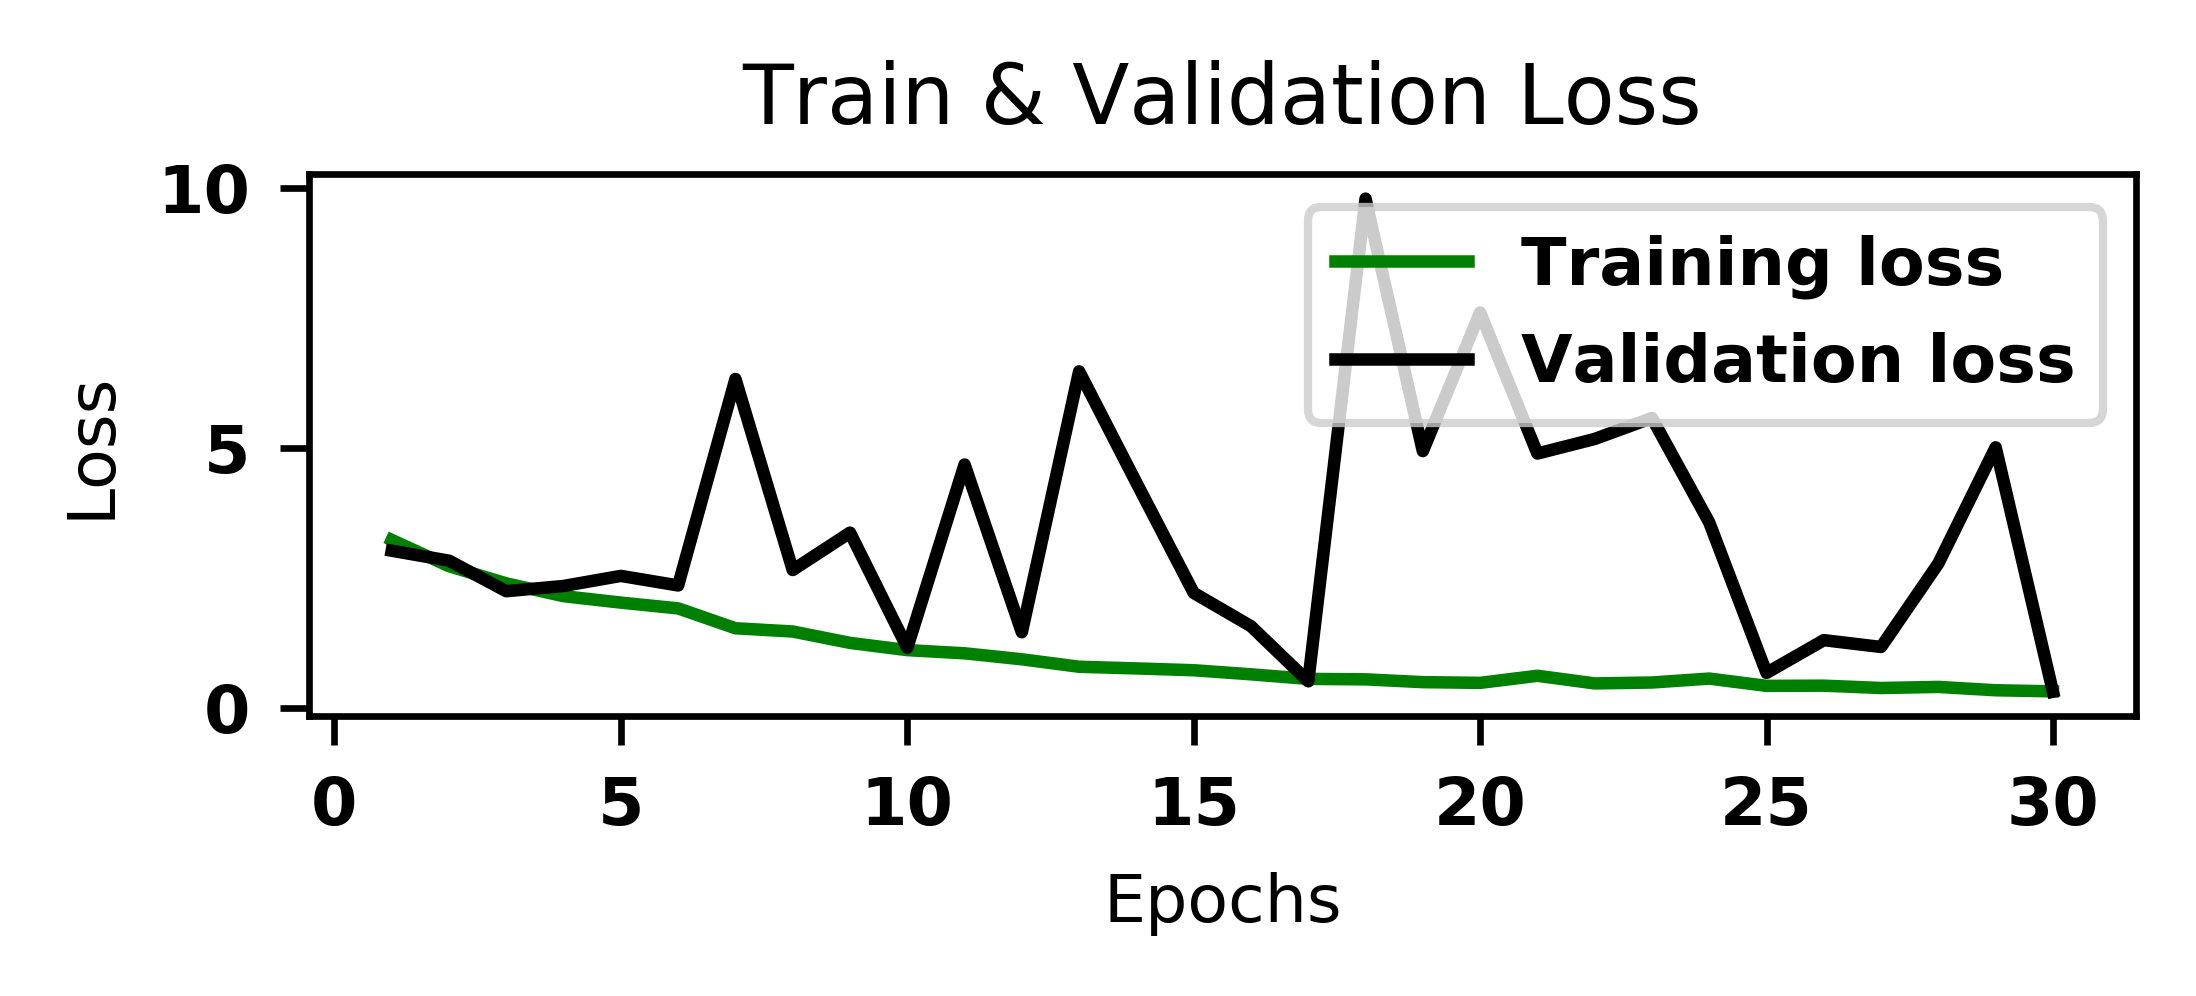

In [88]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
#plt.plot(epochs, loss_train, 'g', label='Training loss')
#plt.plot(epochs, loss_val, 'b', label='validation loss')

fig_loss, ax1 = plt.subplots(figsize = (4,2), dpi = 600) 
ax1 = sns.lineplot(x = epochs, y = loss_train, color ='green', label = 'Training loss')
ax1 = sns.lineplot(x = epochs, y = loss_val, color ='black', label = 'Validation loss')

ax1.set_title('Train & Validation Loss', fontsize = 10)
ax1.set_xlabel("Epochs", fontsize=8)
ax1.set_ylabel('Loss', fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.tick_params(axis='both', which='minor', labelsize=7)
ax1.legend(loc='top left', fontsize=8)
plt.tight_layout()

In [33]:
fig_loss.savefig('tr_val_loss.png', bbox_inches='tight')

Text(0.5, 1, 'F1 Score: 0.98')

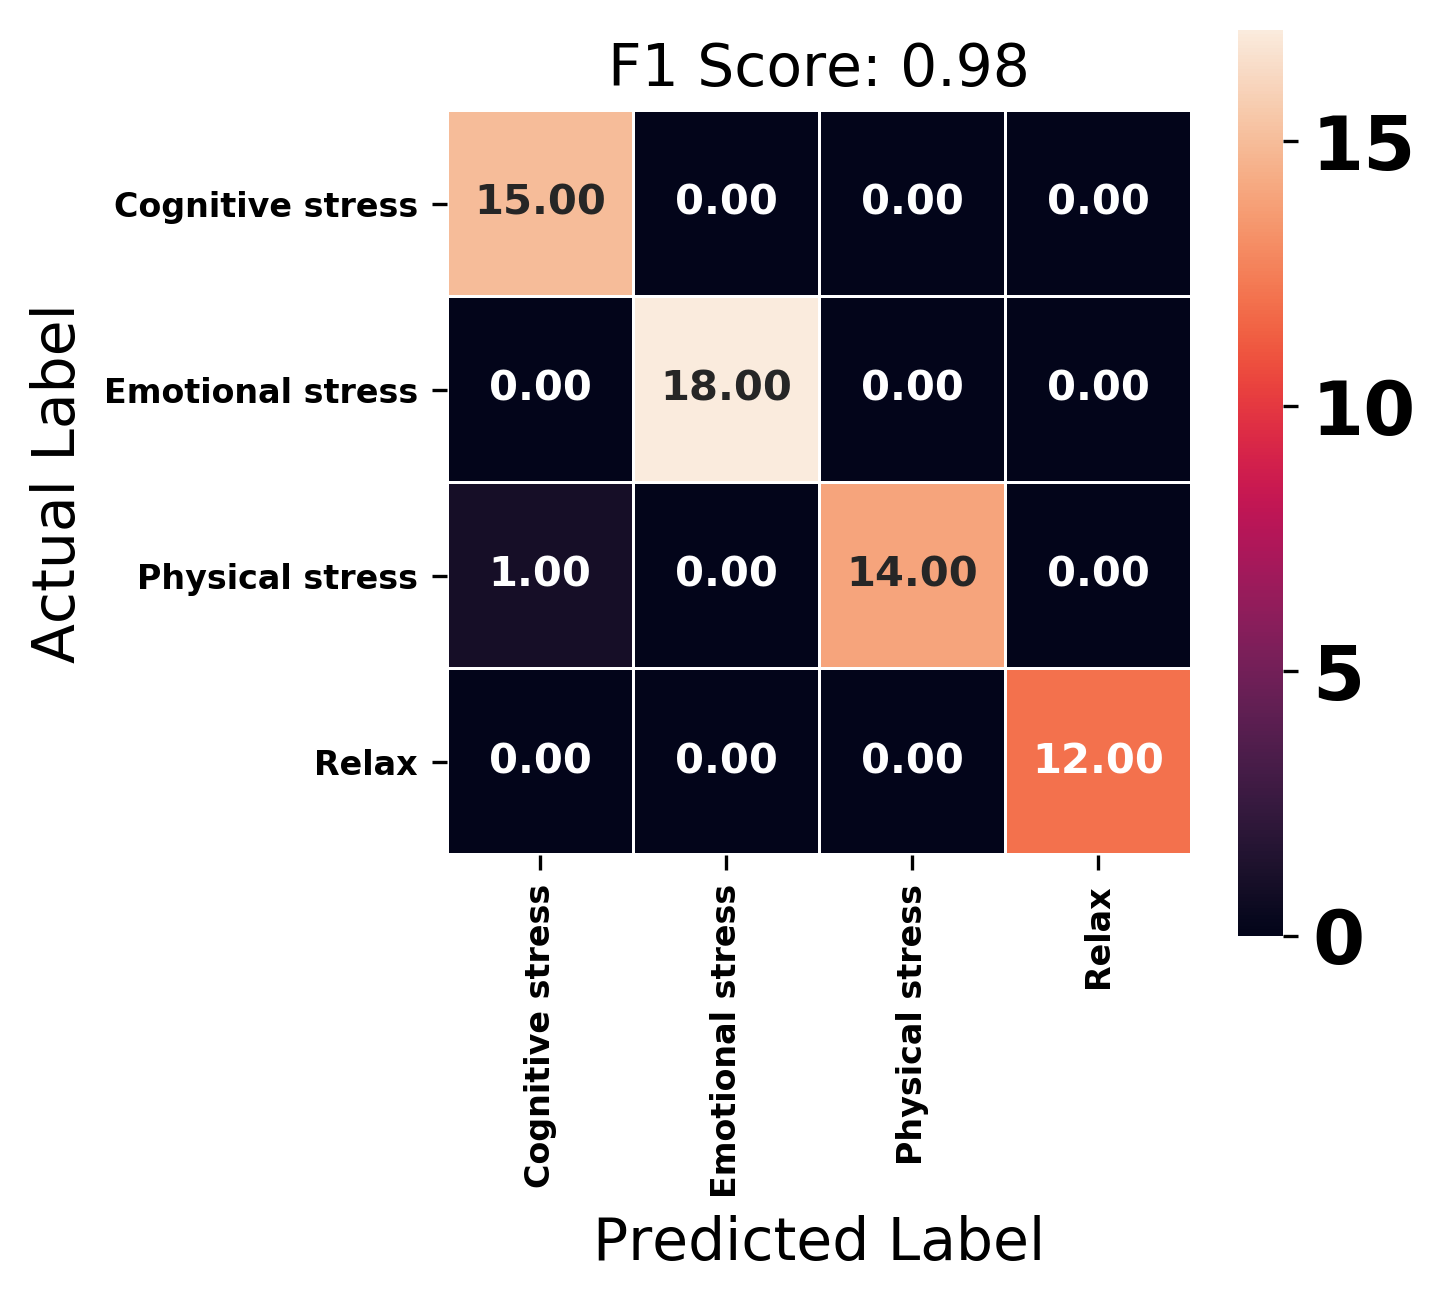

In [58]:

cm = metrics.confusion_matrix(test_y, class_prediction)
#cm
con_m = plt.figure(figsize=(4,4), dpi =300)
ax1 = sns.heatmap(cm, annot=True, annot_kws={"size": 10}, robust=True, fmt='.2f', linewidths=0.5, square =True)#, cmap = 'Blues_r', )
plt.ylabel('Actual Label', fontsize = 14)
plt.xlabel('Predicted Label', fontsize = 14)
#plt.title('LSTM', fontsize = 18)
ticks = ['Cognitive stress', 'Emotional stress', 'Physical stress', 'Relax']
plt.xticks(ticks=[0.5,1.5,2.5,3.5], labels = ticks, rotation = 90 )
plt.yticks(ticks=[0.5,1.5,2.5,3.5], labels = ticks, rotation = 0)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=7)
plt.title('F1 Score: {0:0.2f}'.format(f1_score(test_y, class_prediction, average = 'weighted')), size = 14)

In [42]:
con_m.savefig('lstm_cm_heatmap.png', bbox_inches='tight')

In [49]:
lb = preprocessing.LabelBinarizer()
lb.fit(test_y)
yb_test = lb.transform(test_y)


In [51]:
lb.fit(class_prediction)
class_prediction_b = lb.transform(class_prediction)

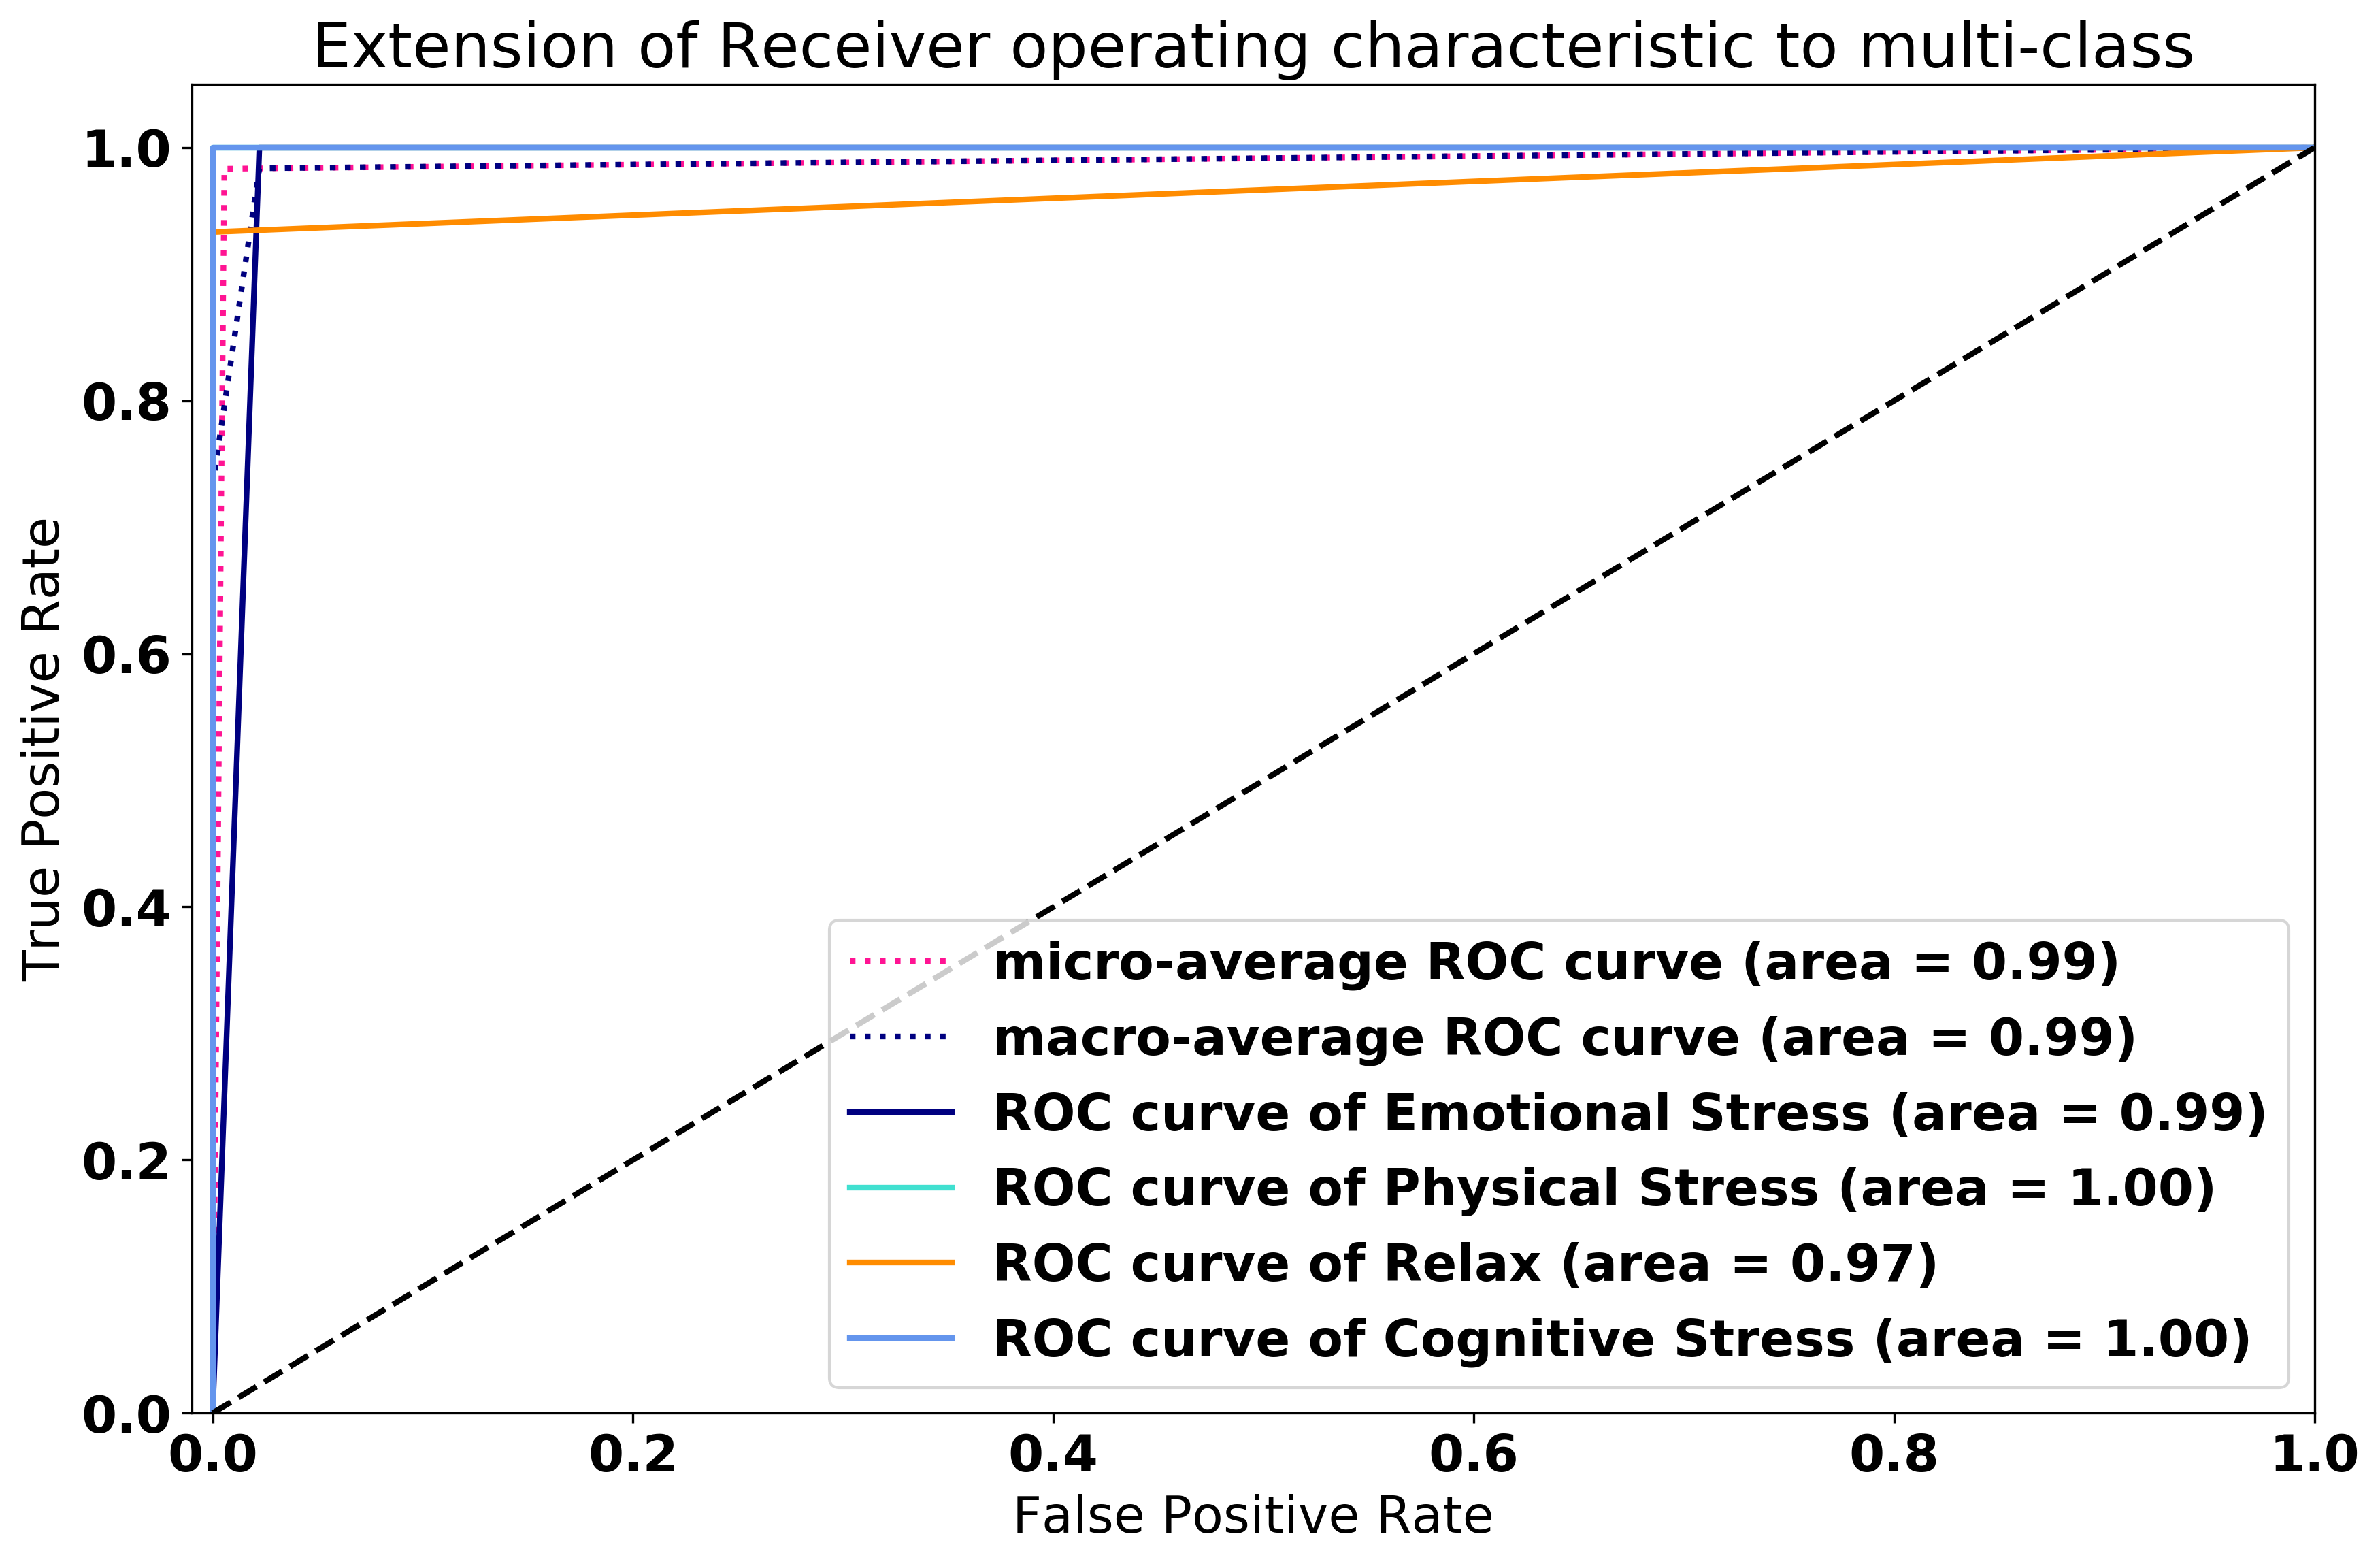

In [55]:
# ROC curve

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'teal'])#, 'blue', 'k'])


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yb_test[:, i], class_prediction_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yb_test.ravel(), class_prediction_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#fig_roc, c_ax = plt.subplots(1,1, figsize = (12, 8))

ROC_plot = plt.figure(figsize=(12, 8), dpi = 300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)
class_names = ['Emotional Stress', 'Physical Stress', 'Relax', 'Cognitive Stress']
for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Extension of Receiver operating characteristic to multi-class', fontsize = 22)
plt.legend(loc="lower right", fontsize = 18)
plt.tight_layout()
plt.show()

In [56]:
ROC_plot.savefig('lstm_ROC.png', bbox_inches='tight')